In [12]:
import gym
from gym.envs.registration import register

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from IPython.display import clear_output

from collections import defaultdict

# Q-Learning


### Frozen lake explained
* Agent has to go from start (S) to the goal (G, a frisbee).
* Agent only gets a reward (1) if it makes it all the way to the end. Otherwise (0).
* There are 4 actions the agent can perform.
* ...but the ice is slippery so sometimes moves in a random direction.

SFFF &nbsp;&nbsp;&nbsp; (S: starting point, safe)<br />
FHFH &nbsp;&nbsp;&nbsp; (F: frozen surface, safe)<br />
FFFH &nbsp;&nbsp;&nbsp; (H: hole, fall to your doom)<br />
HFFG &nbsp;&nbsp;&nbsp; (G: goal, where the frisbee is located)<br />

* there are only 16 states, so carving up a Q-table is an overseeable effort
* 4 actions {0:'left', 1:'down', 2:'right', 3:'up'}

### Create non_slippery environment

In [3]:
# --> Create non-slippery frozen lake

register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78, # optimum = .8196
)

### Example of a deterministic policy, $\pi(a|s)$
Here we define our own policy: follow the outskirts of the map (top and right)

In [4]:
def deterministic_policy(state):
    
    # Go right first
    
    if (state % 3 != 0) or (state == 0):
        action = 2
        
    # Then go down
    else:
        action = 1
    return action

In [5]:
def frozen_lake_deterministic():
    
    env = gym.make("FrozenLakeNotSlippery-v0").env

    s = env.reset()
    done = False
    
    reward = 0
    
    while not done:    
        
        # Get action from policy given the state we are in
        
        a = deterministic_policy(s)

        # perform action
        
        s_next, r, done, info = env.step(a)
        
        # set the next state to the current state
        
        s = s_next
        
        # add up the reward
        
        reward += r

        clear_output()
        env.render()
        time.sleep(1)

    if reward == 0:
        print("\nWe failed :-(")
    else:
        print("\nWe made it! :-D")
        

In [6]:
frozen_lake_deterministic()

  (Down)
SFFF
FHFH
FFFH
HFFG

We failed :-(


### Let's create a Q-learning Agent

In [7]:
class Agent():
    def __init__(self, learning_rate, epsilon, gamma, n_actions):
        """
        Q-Learning Agent
        """
        
        # List possible actions
        self.actions = np.arange(n_actions)

        # Construct a dictionary that holds Q(s, a)
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        
        # Learning rate
        self.learning_rate = learning_rate
        
        # Epsilon: exploration rate
        self.epsilon = epsilon
        
        # Gamma: reward discount
        self.gamma = gamma

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self,state,action,value):
        """ Sets Q(s, a) [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        """
        
        # Get Q values
        Q_values = np.array([self.get_qvalue(state, a) for a in self.actions])
        
        # Get V(s) by taking the max of Q_values
        value = Q_values[Q_values.argmax()]
    
        return value

    def update(self, state, action, reward, next_state, done):
        """
        Update the Q value along our experience
    
        """
        
        gamma = self.gamma
        learning_rate = self.learning_rate

        Q = self.get_qvalue(state, action)
        V = self.get_value(next_state)

        if not done:
            
            Q_hat = Q + learning_rate * (reward + (gamma * V) - Q)
            
        else:
            Q_hat = Q + learning_rate * (reward - Q)
            

                                                                                
        # update Q value in the table
        
        self.set_qvalue(state, action, Q_hat)
    
    def get_best_action(self, state):
        """
        Compute the best action to take in a state by picking the action with the highest Q-value. 
        """
        
        # Get qvalues
        qvalues = np.array([self.get_qvalue(state, a) for a in self.actions])

        # Get best action
        best_action = np.argmax(qvalues)
        
        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon - we should take a random action.
        otherwise - the best action.
        """

        # agent parameters:
        epsilon = self.epsilon

        # Decide if we pick a random action
        if np.random.uniform() < epsilon:
            chosen_action = np.random.choice(self.actions)
        # Else: get the best action
        else:
            chosen_action = self.get_best_action(state)

        return chosen_action
    
    def plot(self, episode, agent, mean_rewards, num_episodes):
    
        clear_output(True)
        print("--- Epoch: %i ---"%episode)
        print('eps =', agent.epsilon, 'mean reward =', mean_rewards[-1])

        # ---> plot reward
        size = (10, 5)
        fig, ax = pyplot.subplots(figsize=size)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=12)
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel('reward', fontsize=12)
        plt.plot(mean_rewards)
        plt.xlim(0, num_episodes/100)
        plt.ylim(0,1)
        plt.show()
        

### Play the game and update the Q-table as we go

In [8]:

def run_episode(env,agent,t_max=10**4, train=False):
    """
    run a full episode along an e-greedy policy
    """
    #  Reset the game
    
    total_reward = 0
    
    s = env.reset()
    
    if not train:
        env.render()
        time.sleep(2)
    
    for t in range(t_max): # max steps, otherwise we quit

        # First we pick an action in the current state
        
        if train:
            a = agent.get_action(s)
        else:
            a = agent.get_best_action(s)
        
        # next, we take a step with this action
        
        next_s, r, done, _ = env.step(a)

        # Finally, given the reward we update the Q-matrix
        
        if train:
            agent.update(s, a, r, next_s, done)
        else:
            clear_output()
            env.render()
            time.sleep(1)
        s = next_s
        total_reward += r
        
        if done: break
    
    return total_reward
    

In [9]:
def frozen_lake_q(num_episodes, gamma, epsilon, epsilon_decay, learning_rate):
    '''
    run a number of episodes
    '''
    
    try: 
        
        # create an environment
        
        env = gym.make("FrozenLakeNotSlippery-v0").env
                
        n_states = env.observation_space.n
        n_actions = env.action_space.n
        
        # create a Q-table
        
        Q_matrix = np.zeros((n_states, n_actions))
        
        rewards = []
        episodes = []
        
        mean_rewards = []

        # create an Agent
        
        agent = Agent(learning_rate=learning_rate, epsilon=epsilon, gamma=gamma, n_actions=n_actions)

        for episode in range(num_episodes+1):
    
            # run an episode
            
            total_reward = run_episode(env, agent, train=True)
            
            rewards.append(total_reward)
            episodes.append(episode)
            
            agent.epsilon *= epsilon_decay

            # plot results for every set of 100 episodes
            
            if episode %100 == 0:
                # Get mean reward in last 10 sessions
                mean_rewards.append(np.mean(rewards))
                
                agent.plot(episode, agent, mean_rewards, num_episodes)
                
                for s, a in np.array(np.meshgrid(np.arange(n_states), np.arange(n_actions))).reshape(2, -1).T:
                    Q_matrix[s, a] = agent.get_qvalue(s, a)
                print(Q_matrix)

                time.sleep(0.25)
                
        return episodes, rewards, agent
    
    finally:
        
        env.close()

--- Epoch: 4000 ---
eps = 0.018242480066854295 mean reward = 0.7185703574106473


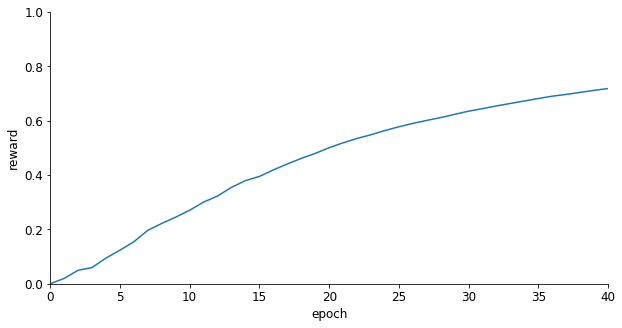

[[0.94148015 0.93206532 0.95099005 0.94148015]
 [0.94148015 0.         0.96059601 0.95099005]
 [0.95099005 0.970299   0.95099    0.96059601]
 [0.96059601 0.         0.84448149 0.85125368]
 [0.88851518 0.75018112 0.         0.94148015]
 [0.         0.         0.         0.        ]
 [0.         0.9801     0.         0.96059595]
 [0.         0.         0.         0.        ]
 [0.25616998 0.         0.91928157 0.66636042]
 [0.59577459 0.98009941 0.87391676 0.        ]
 [0.9702888  0.99       0.         0.97029872]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.93843361 0.99       0.86488423]
 [0.98009336 0.98999963 1.         0.98009419]
 [0.         0.         0.         0.        ]]


In [10]:
gamma = 0.99
epsilon = 0.999
epsilon_decay = 0.999 

num_episodes = 4000
learning_rate = 1e-1

episodes, rewards, agent = frozen_lake_q(num_episodes, gamma, epsilon, epsilon_decay, learning_rate)

### Play the game along the updated Q-table

In [11]:
env = gym.make("FrozenLakeNotSlippery-v0").env

reward = run_episode(env, agent, t_max=10**4, train=False)

if reward == 1:
    print("\nSuccess! :-D")

  (Right)
SFFF
FHFH
FFFH
HFFG

Success! :-D
